In [1]:
from importlib import reload
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [7]:
# import (or reload) modules
import src.models
reload(src.models)
from src.models import *

import src.data_methods
reload(src.data_methods)
from src.data_methods import *

import src.features as features
reload(features)

<module 'src.features' from 'C:\\Users\\Andrew\\Documents\\CeR\\GestRec\\leap_gesture_rec\\src\\features.py'>

## Many To One
This notebook contains the steps necessary to train a 'many to one' lstm model - that is, a model in which many time steps are given as input, and one prediction is given as output.

### Gestures
First, get a list of gestures from the gestures parameter file, and dictionaries mapping between gesture names and their integer ids.

In [5]:
gestures, g2idx, idx2g = get_gestures(version=3)

### Dictionaries for Standardizing/Centering 
Sometimes we want to update the dictionaries used for normalizing and centering variables. We need to do this if a new variable is introduced for which the information is not in the dictionary.
CSV2examples can generate new dictionaries for this purpose, overwriting the old ones stored in the params/ folder.

In [ ]:
n_frames=40
CSV2examples(raw_file='data/recordings/normalization_data.csv', g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, dicts_gen=True, derive_features=True)

### Read in folder of CSV files, set up a model, and train

In [8]:
n_frames = 40
X, y = folder2examples(folder='data/loopsV3/train/', g2idx=g2idx, n_frames=n_frames, mirror=True)
X_val, y_val = folder2examples(folder='data/loopsV3/test/', g2idx=g2idx, n_frames=n_frames, mirror=True)
print(X.shape)

mean fps: 28.78
target fps: 30
taking every 1 frames
98.72% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
mean fps: 27.62
target fps: 30
taking every 1 frames
96.23% of rows contain valid LH data
99.16% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
mean fps: 27.62
target fps: 30
taking every 1 frames
93.07% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
mean fps: 27.61
target fps: 30
taking every 1 frames
96.20% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 1985 of 49769 rows with nans
dealt with 1985 of 49769 rows with nans
Data successfully mirrored
mean fps: 27.61
target fps: 30
taking every 1 frames
98.82% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  Tru

In [9]:
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=len(g2idx), n_lstm_layers=1, rnn_units=4, recurrent_dropout=0.0, bidirectional=True)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 50)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 8)                 1760      
_________________________________________________________________
dense (Dense)                (None, 32)                288       
Total params: 2,048
Trainable params: 2,048
Non-trainable params: 0
_________________________________________________________________


In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.002)
# opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, validation_data=(X_val, y_val), epochs=140, batch_size = 50)

Train on 4156 samples, validate on 768 samples
Epoch 1/140
4156/4156 [==============================] - 6s 1ms/sample - loss: 3.2989 - accuracy: 0.1304 - val_loss: 3.0676 - val_accuracy: 0.2487
Epoch 2/140
4156/4156 [==============================] - 1s 340us/sample - loss: 2.9306 - accuracy: 0.2859 - val_loss: 2.7058 - val_accuracy: 0.3581
Epoch 3/140
4156/4156 [==============================] - 1s 332us/sample - loss: 2.5538 - accuracy: 0.4160 - val_loss: 2.3489 - val_accuracy: 0.4557
Epoch 4/140
4156/4156 [==============================] - 1s 337us/sample - loss: 2.2593 - accuracy: 0.4957 - val_loss: 2.0765 - val_accuracy: 0.5326
Epoch 5/140
4156/4156 [==============================] - 1s 335us/sample - loss: 2.0083 - accuracy: 0.5452 - val_loss: 1.8741 - val_accuracy: 0.5677
Epoch 6/140
4156/4156 [==============================] - 1s 334us/sample - loss: 1.7943 - accuracy: 0.5972 - val_loss: 1.6816 - val_accuracy: 0.6042
Epoch 7/140
4156/4156 [==============================] - 1s 3

In [ ]:
# save trained model
model.save('models/V3/40f_4hs_bi.h5')

In [49]:
# perhaps load another model for comparison
model2 = tf.keras.models.load_model('models/V3/40f_5hs.h5')

### Evaluate model training progress and accuracy

In [24]:
# If required, load a specific CSV of test data
X_test, y_test = CSV2examples('recordings/cputest-maxed.csv', g2idx=g2idx, n_frames=40)

mean fps: 20.82
target fps: 25
taking every 1 frames
100.00% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 1600 rows with nans
dealt with 0 of 1600 rows with nans
Data successfully mirrored


In [20]:
# predict on a random test case
i = np.random.randint(0, len(X_test))
print('Example number ',i)
pred = model.predict(np.expand_dims(np.array(X_test[i]), axis=0))
print('Probability: ', np.max(pred))
print('Predicted: ', idx2g[np.argmax(pred)])
print('Truth: ', idx2g[y_test[i]])

76
[[5.1329839e-03 1.2742927e-04 1.3233292e-03 8.1423987e-03 3.8563199e-02
  1.0936646e-02 7.2512496e-01 2.1064912e-01]]
Predicted:  shuffle_over
Truth:  shuffle_over


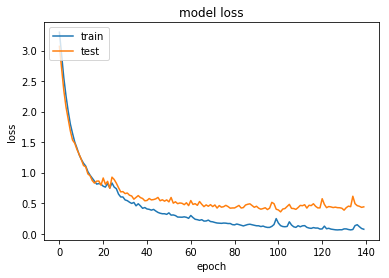

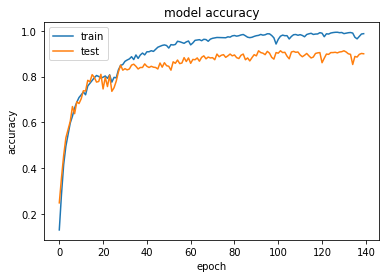

In [11]:
# plot training history
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [12]:
# get accuracy for each gesture
# this acheives this using pd.crosstab, which essentially gets the confusion matrix

pred = np.argmax(model.predict(X_val), axis=-1)

c_matrix = pd.crosstab(y_val, pred, rownames=['Actual'], colnames=['Predicted'], normalize='index')

accuracy = {g: 0 for g in g2idx.keys()}
for i in c_matrix.index:
    if i not in c_matrix.columns:
        pass
    else:
        accuracy[idx2g[i]] = round(c_matrix.loc[i,i],2)

print(sorted(accuracy.items(), key=lambda x: x[1]))

[('open_close', 0.58), ('wave', 0.58), ('stop', 0.62), ('typing', 0.67), ('thumbs_up', 0.79), ('small', 0.79), ('this_big', 0.83), ('smoothing_sand', 0.83), ('drawing', 0.83), ('love_heart_set', 0.88), ('multiple', 0.92), ('driving', 0.92), ('why', 0.92), ('gather_leaves', 0.92), ('robotic_arm', 0.92), ('fist', 0.96), ('gun', 0.96), ('shuffle_over', 0.96), ('counting_hands_together', 0.96), ('finger_drawing', 0.96), ('no_gesture', 1.0), ('call_me', 1.0), ('maybe', 1.0), ('ok', 1.0), ('peace', 1.0), ('pointing', 1.0), ('so_so', 1.0), ('thumbs_down', 1.0), ('triangle_set', 1.0), ('circle_set', 1.0), ('path', 1.0), ('cup_hands', 1.0)]


('middle_finger', 0.04), ('wave', 0.46), ('multiple', 0.75), ('thumbs_up', 0.83), ('small', 0.83), ('smoothing_sand', 0.83), ('counting_hands_together', 0.88), ('finger_drawing', 0.88), ('fist', 0.92), ('gun', 0.92), ('this_big', 0.92), ('driving', 0.92), ('drawing', 0.92), ('peace', 0.96)

Wave and middle finger most urgent, not being recognized at all.
stop and peace, redo. 

In [129]:
# get confusion matrix
pred = np.argmax(model.predict(X), axis=-1)

c_matrix = pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted'], normalize='index')

accuracy = {g: 0 for g in g2idx.keys()}
for i in c_matrix.index:
    if i not in c_matrix.columns:
        pass
    else:
        accuracy[idx2g[i]] = round(c_matrix.loc[i,i],2)

print(sorted(accuracy.items(), key=lambda x: x[1]))

[('finger_drawing', 0.92), ('small', 0.95), ('multiple', 0.95), ('thumbs_up', 0.96), ('pointing', 0.97), ('thumbs_down', 0.97), ('robotic_arm', 0.97), ('no_gesture', 0.98), ('open_close', 0.98), ('peace', 0.98), ('shuffle_over', 0.98), ('wave', 0.98), ('middle_finger', 0.98), ('smoothing_sand', 0.98), ('call_me', 0.99), ('so_so', 0.99), ('stop', 0.99), ('typing', 0.99), ('counting_hands_together', 0.99), ('path', 0.99), ('drawing', 0.99), ('fist', 1.0), ('gun', 1.0), ('maybe', 1.0), ('ok', 1.0), ('this_big', 1.0), ('triangle_set', 1.0), ('circle_set', 1.0), ('love_heart_set', 1.0), ('driving', 1.0), ('why', 1.0), ('gather_leaves', 1.0), ('cup_hands', 1.0)]
